In [1]:
import numpy as np
import pandas as pd
import os
import csv
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import keras as kr
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Input, Bidirectional, TimeDistributed, GRU, LSTM, BatchNormalization, ConvLSTM2D, Concatenate
from subprocess import call
import glob
import Automold as am
import Helpers as hp

Using TensorFlow backend.


# Video frames extraction

In [2]:
# You can use your own data directories
frame_dir = './data_comma/data_frames'
#label_dir = './data_comma/train.txt'
labels_file = './data_comma/Data.csv'

def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels['VideoFrames'].values
    y = labels['Speeds'].values
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    #X_train, X_test, y_train, y_test = X[int(len(X)*(test_size/2)):], X[:int(len(X)*(test_size))], y[int(len(X)*(test_size/2)):], y[:int(len(X)*(test_size))]
    X_train, X_test, y_train, y_test = X[:int(len(X)*(1-test_size))], X[int(len(X)*(1-test_size)):], y[:int(len(X)*(1-test_size))], y[int(len(X)*(1-test_size)):]
    
    return X_train, X_test, y_train, y_test

def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


data = load_data(labels_file, 0.1)

# Image preprocessing

In [3]:
def random_flip(data_dir, image_file, speed):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
    image = load_image(data_dir, image_file)
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        speed = speed
    return image, speed

def random_shift(image, speed, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertival translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.3)
    trans_y = range_y * (np.random.rand() - 0.3)
    speed += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, speed

def random_shadow(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    bright_factor = 0.75
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def random_brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    image= am.brighten(image, 0.56)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #ratio = 1.3 + (np.random.rand() - 0.05)
    ratio = 1.25
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def augument(data_dir, image_file, speed, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, speed = random_flip(data_dir, image_file, speed)
    image, speed = random_shift(image, speed, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, speed

def preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[100:360, :-90, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img =cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

batch_size, time_step = 20, 4
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 220, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE1 = (time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE2 = (time_step,)

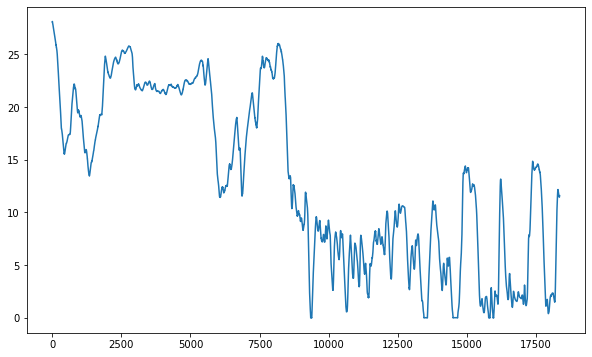

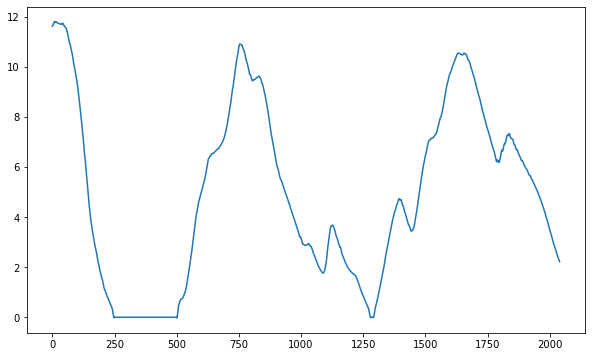

In [4]:
from scipy.signal import savgol_filter
plt.figure(figsize=(10,6))
vel = savgol_filter(data[2], 11, 3)
plt.plot(vel)
plt.show()

plt.figure(figsize=(10,6))
vel1 = savgol_filter(data[3], 11, 3)
plt.plot(vel1)
plt.show()

# Acceleration extraction

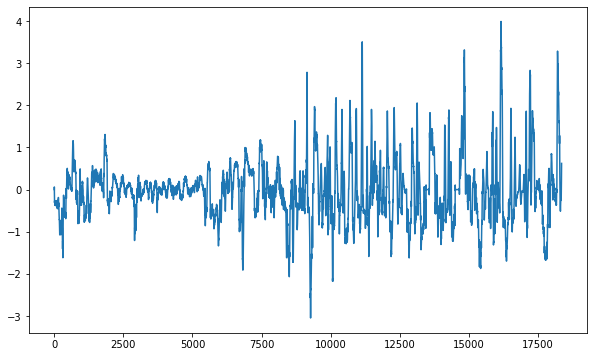

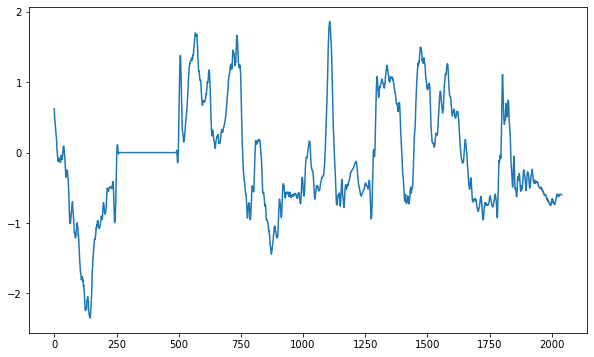

In [5]:
acc_train = np.diff(vel)/0.05
acc_train_filt = savgol_filter(acc_train, 17, 2)

acc_train = np.diff(vel1)/0.05
acc_test_filt = savgol_filter(acc_train, 17, 2)

acc_train_filt = np.append(0, acc_train_filt)
acc_test_filt = np.append(acc_train_filt[-1], acc_test_filt)

plt.figure(figsize=(10,6))
plt.plot(acc_train_filt)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(acc_test_filt)
plt.show()

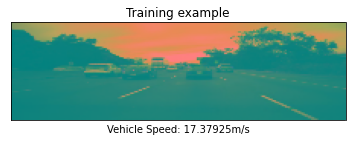

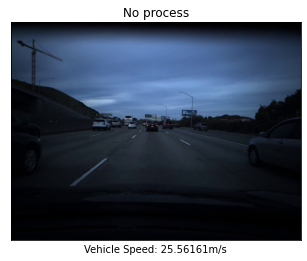

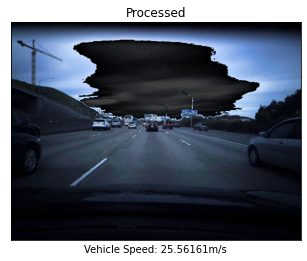

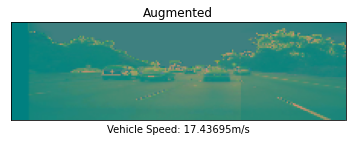

In [10]:
# Check the image
image = load_image(frame_dir, str(data[0][1116]))
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Vehicle Speed: {:.5f}".format(angle)+"m/s")
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

veh_speed = data[2][1116]
display(preprocess(image), veh_speed, "Training example")

image = load_image(frame_dir, str(data[0][156]))
speed = data[2][156]
label = "No process"
display(image, speed, label)

image1 = random_brightness(image)
label = "Processed"
display(image1, speed, label)

image2, veh_speed = augument(frame_dir, str(data[0][1116]), data[2][1116])
image2 = preprocess(image2)
label = "Augmented"
display(image2, veh_speed, label)

In [7]:
# The CNN-BGRU model
def N2N_model1():
    data = Input(shape=INPUT_SHAPE1)
    convs = Sequential()
    convs.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    convs.add(Conv2D(24, (5, 5), activation='elu', padding = 'same', strides=(2, 2)))
    convs.add(Conv2D(36, (5, 5), activation='elu', padding = 'same', strides=(2, 2)))
    convs.add(Conv2D(48, (5, 5), activation='elu', padding = 'same', strides=(2, 2)))
    convs.add(Dropout(0.5))
    convs.add(Conv2D(64, (3, 3), activation='elu', padding = 'same', strides=(1, 1)))
    convs.add(Conv2D(64, (3, 3), activation='elu', padding = 'same', strides=(1, 1)))
    convs.add(MaxPooling2D((2, 2), strides=(1,1)))
    #convs.add(GlobalAveragePooling2D())
    convs.add(Dropout(0.5))
    convs.add(Flatten())
    
    recu = TimeDistributed(convs)(data)
    recu = Bidirectional(GRU(300, activation='relu', recurrent_activation='hard_sigmoid', return_sequences=False))(recu)
    
    recu = Dropout(0.5)(recu)
    #recu = Dense(1000)(recu)
    #recu = Dropout(0.3)(recu)
    recu = Dense(120, activation='elu')(recu)
    recu = Dropout(0.3)(recu)
    recu = Dense(60, activation='elu')(recu)
    recu = Dropout(0.3)(recu)
    recu = Dense(10, activation='elu')(recu)
    recu = Dropout(0.1)(recu)
    recu = Dense(1)(recu)

    model = Model(inputs=data, outputs=recu)
    model.summary()
    return model

# Training usage

In [7]:
batch_size, time_step = 20, 4
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 220, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE1 = (time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
INPUT_SHAPE2 = (time_step,)

samples_per_epoch = len(data[0])//batch_size
nb_epoch = 50

def batcher(data_dir, image_paths, speeds, batch_size, training_flag):
    images = np.empty([batch_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    veh_speeds = np.empty(batch_size)
    while True:
        i = 0
        for j in np.random.permutation(np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int)):
            idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
            for index in range(0,idx_X.shape[0]):
                ii = idx_X[index]
                image = image_paths[ii]
                veh_speed = speeds[ii]
                if training_flag and np.random.rand() < 0.6:
                    image, veh_speed = augument(data_dir, image, veh_speed)
                else:
                    image = load_image(data_dir, image)
                images[i,index,:] = preprocess(image)
            veh_speeds[i] = veh_speed
            i += 1
            if i == batch_size:
                break
        yield images, veh_speeds
        
def train_model(model, X_train, X_valid, y_train, y_valid):
    checkpoint = ModelCheckpoint('model_best_a.h5',
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.01e-4,beta_1=0.9, beta_2=0.999, decay=0., amsgrad=False))
    history = model.fit_generator(batcher(frame_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        epochs = nb_epoch,
                        max_queue_size=1,
                        validation_data=batcher(frame_dir, X_valid, y_valid, batch_size, False),
                        #nb_val_samples=len(X_valid),
                        validation_steps=len(X_valid)//batch_size,
                        use_multiprocessing = False,
                        callbacks=[checkpoint],
                        verbose=1)
    return history

# Training

In [ ]:
# Model training
model = N2N_model1()
history = train_model(model, *data)
model.save('N2Ncomma_speed.h5')

# Testing

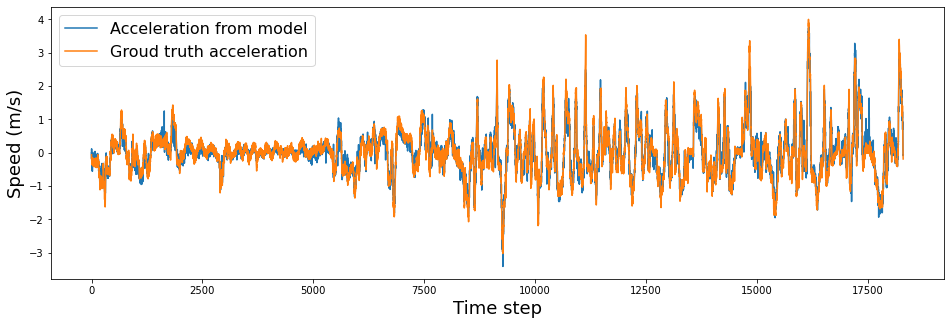

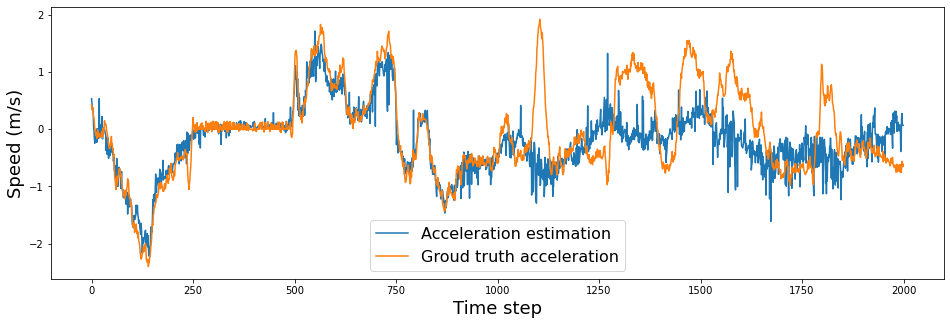

In [8]:
# Can skip the training and load the trained model, but make sure you load the data based on the input of the model
# For the model 'N2Nmodel_acceleration.h5', the input shape will be (batch size, time_step=2, image_height=66,image_height=220,channels=3)
import tensorflow
def getTestData(data_dir, image_paths, speeds, t_size, time_step, start):
    images = np.empty([t_size, time_step, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    veh_speeds = np.empty(t_size)
    i, i_start = 0, start
    for j in np.linspace(time_step, image_paths.shape[0], image_paths.shape[0]-time_step+1, dtype=int):
        idx_X = np.linspace(j-time_step,j-1,time_step, dtype = int)
        for index in range(0,idx_X.shape[0]):
            ii = idx_X[index]
            image = image_paths[ii]
            veh_speed = speeds[ii]
            if np.random.rand() < 0.6:
                image, veh_speed = augument(data_dir, image, veh_speed)
            else:
                image = load_image(data_dir, image)
            images[i,index,:] = preprocess(image)
        veh_speeds[i] = veh_speed
        i += 1
        i_start += 1
        if i_start == start+t_size:
            break
    return images, veh_speeds

start1, start2 = 0, 0
t_size, t_size1 = 18300, 2000
data_Train = getTestData(frame_dir, data[0], acc_train_filt, t_size, time_step, start1)
data_Test = getTestData(frame_dir, data[1], acc_test_filt, t_size1, time_step, start2)

#data_Test[0].shape
model =  tensorflow.keras.models.load_model('N2Ncomma_1118_a.h5')
speed_train = model.predict(data_Train[0])
speed_test = model.predict(data_Test[0])

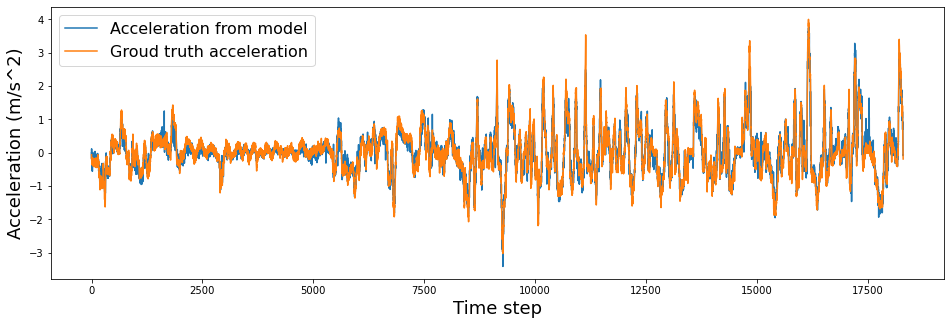

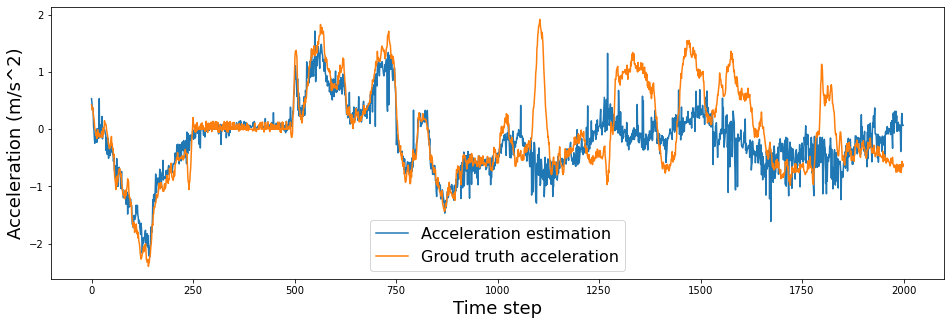

In [9]:
plt.figure(figsize=(16,5))
plt.plot(speed_train, label='Acceleration from model')
plt.plot(data_Train[1], label='Groud truth acceleration')
#plt.title('Trained model')
plt.xlabel('Time step', fontsize=18)
plt.ylabel('Acceleration (m/s^2)', fontsize=18)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(speed_test, label='Acceleration estimation')
plt.plot(data_Test[1], label='Groud truth acceleration')
#plt.title('Testing model')
plt.xlabel('Time step', fontsize=18)
plt.ylabel('Acceleration (m/s^2)', fontsize=18)
plt.legend(fontsize=16)
plt.show()